# 21 Period Moving Average Reversion Strategy

In [1]:
#!pip install oandapyV20

In [2]:
#!pip install zulu

In [3]:
#!pip install mpl_finance

In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

In [3]:
client = oandapyV20.API(access_token=token)

# 21 Period Moving Average Reversion strategy on EURUSD

In [5]:
# Loop to create the dataset

Date = pd.Series(datetime.datetime(2010, 4, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=15)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M5"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)
    
#Adjusting so that eurusd and Date match
Date = Date.drop(index=0)
eurusd = eurusd.drop(index=0)

eurusd.index = range(eurusd.shape[0])
Date.index = range(eurusd.shape[0])

eurusd.head()

,Time,Open,High,Low,Close
0,733863.0139,1.3539,1.3556,1.3539,1.3554
1,733863.0174,1.3555,1.3562,1.3551,1.3552
2,733863.0208,1.3552,1.3553,1.3544,1.3545
3,733863.0243,1.3546,1.3554,1.3545,1.3549
4,733863.0278,1.3549,1.3550,1.3545,1.3546


In [6]:
#First and Last Day of the dataset
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(746005, 5)
2010-04-01 00:20:00
2020-04-01 22:35:00
         Time   Open   High    Low  Close
0 733863.0139 1.3539 1.3556 1.3539 1.3554
1 733863.0174 1.3555 1.3562 1.3551 1.3552
2 733863.0208 1.3552 1.3553 1.3544 1.3545
3 733863.0243 1.3546 1.3554 1.3545 1.3549
4 733863.0278 1.3549 1.3550 1.3545 1.3546


In [224]:
#Export and Import the dataset
#eurusd.to_csv(os.getcwd()+'\\eurusd5minMA.csv')
eurusd = pd.read_csv(os.getcwd()+'\\eurusd5minMA.csv', index_col=0)

### Definition of the Moving Average

In [225]:
def CrossMovingAverage(rates, fast_period, slow_period):
    fastMA=[]
    slowMA=[]
    
    fastMA = eurusd['Close'].rolling(fast_period).mean()
    slowMA= eurusd['Close'].rolling(slow_period).mean()
        
    return slow_period, fastMA, slowMA

In [226]:
slow_period, fastMA, slowMA = CrossMovingAverage(eurusd, 8, 21)

eurusd["fastMA"] = fastMA
eurusd["slowMA"] = slowMA

eurusd = eurusd.iloc[21:]
eurusd.index = range(eurusd.shape[0])

data = {'close':eurusd["Close"],'fastMA':fastMA, 'slowMA':slowMA}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:21])
flag.index = range(flag.shape[0])

In [227]:
plt.style.use('ggplot')

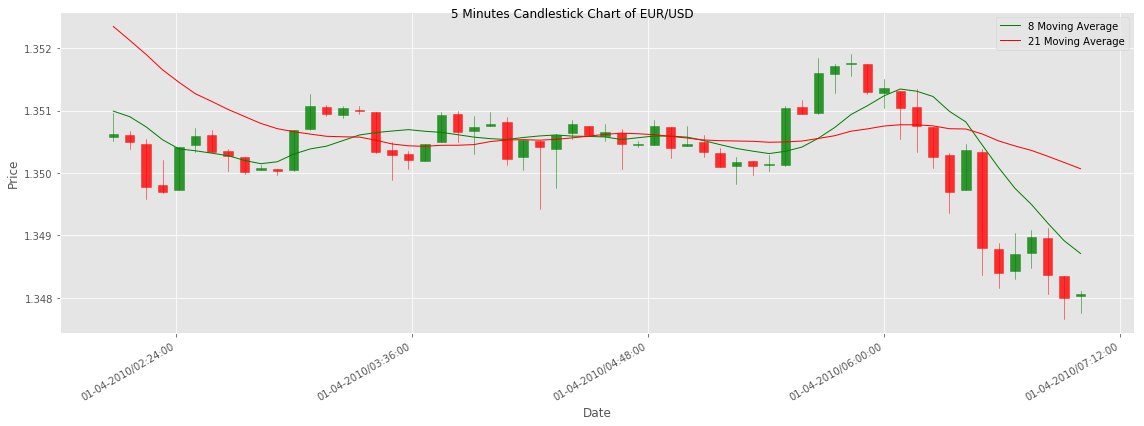

In [228]:
# Creating Subplots
fig, ax = plt.subplots(figsize = (16,6))

candlestick_ohlc(ax, eurusd.iloc[range(60), range(5)].values, width=0.002, colorup='green', colordown='red', alpha=0.8)
ax.plot(eurusd['Time'][:60], eurusd["fastMA"][:60], color = 'green', linewidth = 1, label='8 Moving Average')
ax.plot(eurusd['Time'][:60], eurusd["slowMA"][:60], color = 'red', linewidth = 1, label='21 Moving Average')
leg = ax.legend();

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('5 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [229]:
print(eurusd.shape)
print(flag.shape)

(745984, 7)
(745984, 3)


### Strategy - buy or sell if the price is far from the 21 Moving Average

In [230]:
# Creating boolean values if the below conditions are true
flag["distance"] = np.where(flag["close"] >= flag["slowMA"], (flag["close"]-flag["slowMA"])*10000, (flag["close"]-flag["slowMA"])*10000 )

In [231]:
flag.head(10)

,close,fastMA,slowMA,distance
0,1.3506,1.3510,1.3523,-16.9714
1,1.3507,1.3509,1.3521,-13.9524
2,1.3508,1.3507,1.3519,-11.0857
3,1.3502,1.3505,1.3517,-14.2286
4,1.3505,1.3504,1.3515,-9.2333
5,1.3504,1.3504,1.3513,-8.5952
6,1.3506,1.3503,1.3511,-5.4619
7,1.3508,1.3503,1.3510,-2.3714
8,1.3506,1.3502,1.3509,-2.9476
9,1.3507,1.3501,1.3508,-1.3286


In [232]:
flag["buyTrigger"] = 0
flag["buyWin"] = 0 
flag["sellTrigger"] = 0 
flag["sellWin"] = 0 

In [233]:
flag["buyTrigger"] = np.where(flag["distance"]<-0.01, 1,0)
flag["buyWin"] = np.where(flag["distance"]>0, 1,0)
flag["sellTrigger"] = np.where(flag["distance"]>0.01, 1,0)
flag["sellWin"] = np.where(flag["distance"]<0, 1,0)

flag.head(13)

,close,fastMA,slowMA,distance,buyTrigger,buyWin,sellTrigger,sellWin
0,1.3506,1.3510,1.3523,-16.9714,1,0,0,1
1,1.3507,1.3509,1.3521,-13.9524,1,0,0,1
2,1.3508,1.3507,1.3519,-11.0857,1,0,0,1
3,1.3502,1.3505,1.3517,-14.2286,1,0,0,1
4,1.3505,1.3504,1.3515,-9.2333,1,0,0,1
5,1.3504,1.3504,1.3513,-8.5952,1,0,0,1
6,1.3506,1.3503,1.3511,-5.4619,1,0,0,1
7,1.3508,1.3503,1.3510,-2.3714,1,0,0,1
8,1.3506,1.3502,1.3509,-2.9476,1,0,0,1
9,1.3507,1.3501,1.3508,-1.3286,1,0,0,1


_I defines a winning trade when a Trigger column is equal to 1 and then the corresponding Win column is 1_

In [234]:
flagBuy = flag.drop(["sellTrigger","sellWin"], axis=1)
flagSell = flag.drop(["buyTrigger","buyWin"], axis=1)

## Long Side

In [238]:
# I create a data frame with values of the maximum distance from the slow MA of every buy order
prev = 0
# the array splits shows me the indeces where the column changes value
splits = np.append(np.where(np.diff(flagBuy["buyTrigger"]) != 0)[0],len(flagBuy["buyTrigger"]))
maxBuyDistance = []
count = []
averagePrice = []
exit = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagBuy["buyTrigger"].size,1)[prev:split]
    maxBuyDistance.append(min(flagBuy.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagBuy.loc[indici]["close"].mean())
    exit.append(flagBuy.loc[split+1]["close"])
    prev = split

In [244]:
data = {'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxBuyDistance':maxBuyDistance}
long = pd.DataFrame(data=data, index=range(len(maxBuyDistance)))


long['pips'] = (long["Exit"] - long["AveragePrice"])*10000
long["size"] = long["TradeExecuted"]*2000
long["P/L"] = long["size"]*(long["Exit"] - long["AveragePrice"])

long=long[['AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxBuyDistance']]

long = long[::2]
long.index = range(long.shape[0])

long.head(5)

,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxBuyDistance
0,1.3506,1.3507,11,22000,1.8091,3.9800,-14.2286
1,1.3502,1.3510,7,14000,7.9286,11.1000,-4.3571
2,1.3490,1.3508,16,32000,18.0625,57.8000,-25.1667
3,1.3502,1.3508,6,12000,6.3000,7.5600,-11.4857
4,1.3506,1.3507,1,2000,1.6000,0.3200,-0.4476


## Short Side

In [247]:
# I create a data frame with values of the maximum distance from the slow MA of every sell order
prev = 0
# the array splits shows me the indeces where the column changes value
splits = np.append(np.where(np.diff(flagSell["sellTrigger"]) != 0)[0],len(flagSell["sellTrigger"]))
maxSellDistance = []
count = []
averagePrice = []
exit = []

for split in splits[:-2]:
    
    indici = []
    
    # indici is a list of indices of rows that have consecutively the same value
    indici = np.arange(1,flagSell["sellTrigger"].size,1)[prev:split]
    maxSellDistance.append(min(flagSell.loc[indici]["distance"]))
    count.append(len(indici))
    averagePrice.append(flagSell.loc[indici]["close"].mean())
    exit.append(flagSell.loc[split+1]["close"])
    prev = split

In [253]:
data = {'AveragePrice':averagePrice, 'Exit':exit, 'TradeExecuted':count, 'maxSellDistance':maxSellDistance}
sell = pd.DataFrame(data=data, index=range(len(maxSellDistance)))


sell['pips'] = (sell["AveragePrice"] - sell["Exit"])*10000
sell["size"] = sell["TradeExecuted"]*2000
sell["P/L"] = sell["size"]*(sell["AveragePrice"] - sell["Exit"])

sell=sell[['AveragePrice', 'Exit', 'TradeExecuted', "size", 'pips', "P/L", 'maxSellDistance']]

sell = sell[1::2]
sell.index = range(sell.shape[0])

sell.head(5)

,AveragePrice,Exit,TradeExecuted,size,pips,P/L,maxSellDistance
0,1.3507,1.3504,1,2000,3.5000,0.7000,1.2762
1,1.3513,1.3503,9,18000,10.2000,18.3600,1.9810
2,1.3508,1.3506,1,2000,2.0000,0.4000,1.7095
3,1.3508,1.3506,1,2000,2.2000,0.4400,0.9619
4,1.3506,1.3494,2,4000,11.7000,4.6800,0.0810


## Stats: 21 Period Moving Average Reversion Strategy

### Long Side

In [254]:
print("Long trades: " + str(len(long["maxBuyDistance"])))
print("P/L: " + str(long["P/L"].sum()))
print("Average max distance from the 21 period MA: " + str(long["maxBuyDistance"].mean()))

Long trades: 24863
P/L: 51209.200000000375
Average max distance from the 21 period MA: -10.531048239550433


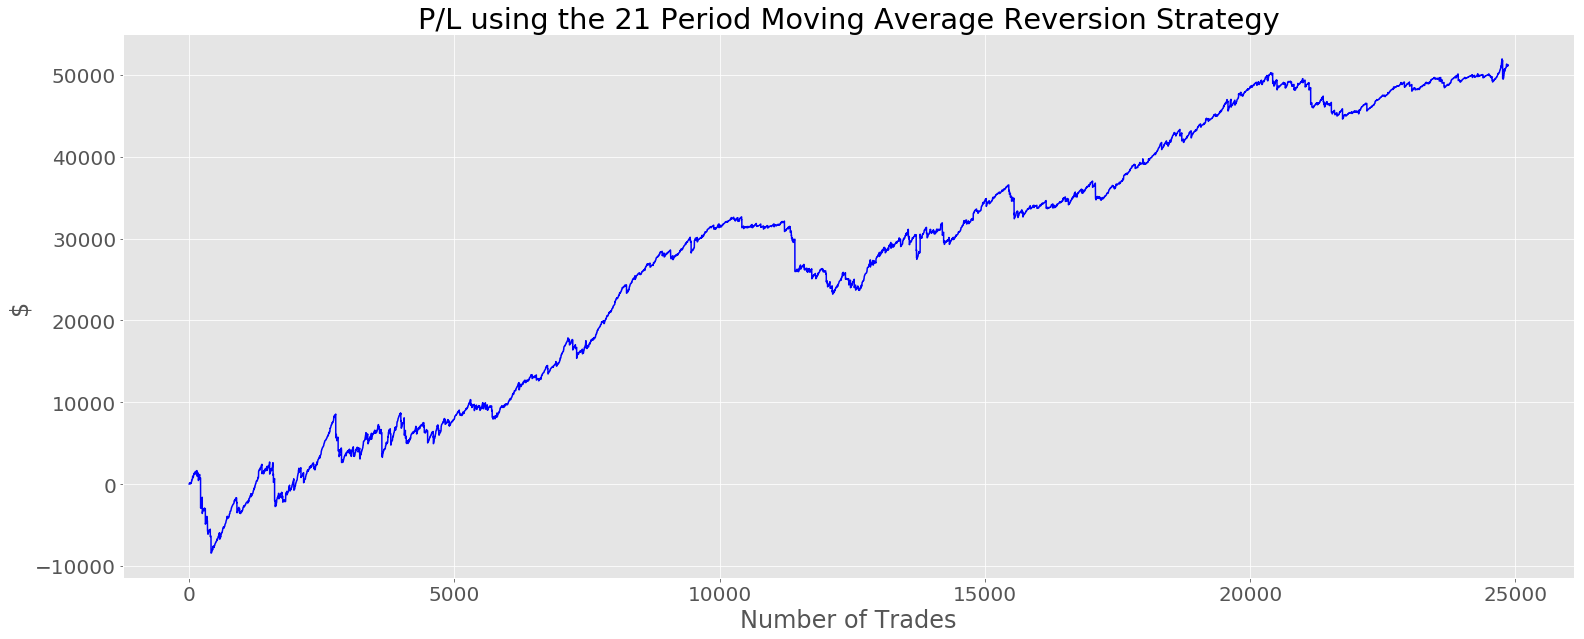

In [262]:
PL = pd.Series(np.cumsum(long["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 21 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})

### Short Side

In [255]:
print("Short trades: " + str(len(sell["maxSellDistance"])))
print("P/L: " + str(sell["P/L"].sum()))
print("Average max distance from the 21 period MA: " + str(sell["maxSellDistance"].mean()))

Short trades: 24856
P/L: 46090.60000000042
Average max distance from the 21 period MA: 1.1381218677126603


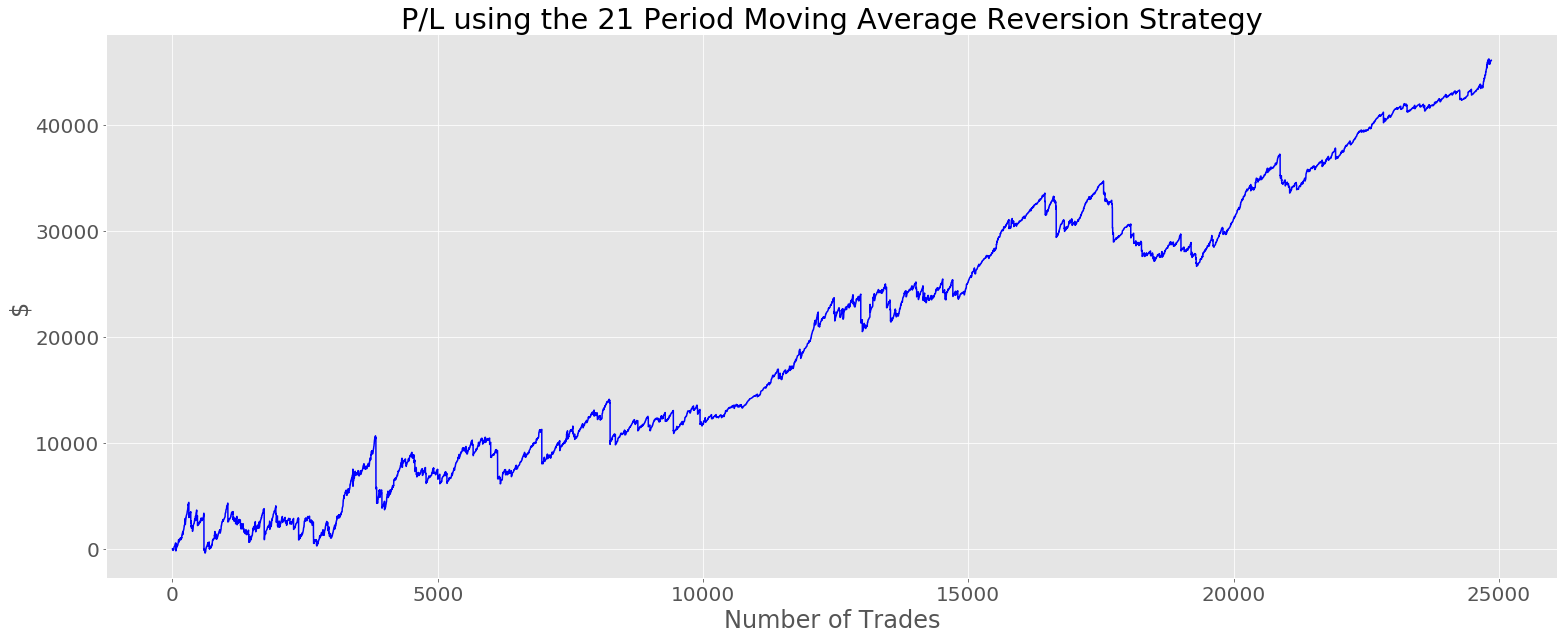

In [261]:
PL = pd.Series(np.cumsum(sell["P/L"]))


plt.figure(figsize=(26, 10), facecolor='w', edgecolor='k');
PL.plot(color='blue');
plt.title("P/L using the 21 Period Moving Average Reversion Strategy", loc='center', pad=None)
plt.ylabel("$");
plt.xlabel("Number of Trades");
plt.rcParams.update({'font.size': 20})